In [30]:
import pandas as pd
import datetime
import numpy as np
import matplotlib .pyplot as plt
%matplotlib inline
import quandl

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler(feature_range=(0, 1))
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors

# quandl API Key
from config import api_key

In [31]:
from matplotlib .pyplot import rcParams
rcParams['figure.figsize'] = 20,10

In [553]:
quandl.ApiConfig.api_key = api_key
df = quandl.get_table('WIKI/PRICES', paginate=True,ticker = \
                      ['AAPL', 'AMZN', 'CSCO','CMCSA','GOOGL','INTC','MSFT','VZ','DIS','WMT'],\
                      date = { 'gte': '2008-01-01', 'lte': '2018-12-30' })

In [554]:
# Return non-NAN rows in each column
df.count()

ticker         25756
date           25756
open           25756
high           25756
low            25756
close          25756
volume         25756
ex-dividend    25756
split_ratio    25756
adj_open       25756
adj_high       25756
adj_low        25756
adj_close      25756
adj_volume     25756
dtype: int64

In [555]:
# Return total number of rows including NAN in the dataframe
df.size

360584

In [556]:
#Show shape of the dataset
print(df.shape)

(25756, 14)


In [558]:
#Extract and create new feature from 'date'
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['day_of_year'] = df.date.dt.dayofyear
df['week_of_year'] = df.date.dt.weekofyear
df['day_of_week'] = df.date.dt.dayofweek
df['day_of_week_name'] = df.date.dt.day_name()
df['quarter'] = df.date.dt.quarter
df['mon_fri'] = 0
for index in df.index:
    if df.loc[index, 'day_of_week']==0 or df.loc[index, 'day_of_week']==4:
        df.loc[index,'mon_fri'] = 1
    else:
        df.loc[index,'mon_fri'] = 0

In [559]:
df.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,...,adj_volume,year,month,day,day_of_year,week_of_year,day_of_week,day_of_week_name,quarter,mon_fri
None,,,,,,,,,,,,,,,,,,,,,
0,WMT,2018-03-27,87.96,88.04,85.48,86.05,6395554.0,0.0,1.0,87.96,...,6395554.0,2018,3,27,86,13,1,Tuesday,1,0
1,WMT,2018-03-26,86.22,87.69,86.11,87.50,8640866.0,0.0,1.0,86.22,...,8640866.0,2018,3,26,85,13,0,Monday,1,1
2,WMT,2018-03-23,87.35,87.74,85.28,85.42,9762296.0,0.0,1.0,87.35,...,9762296.0,2018,3,23,82,12,4,Friday,1,1
3,WMT,2018-03-22,87.53,88.27,86.99,87.14,11338049.0,0.0,1.0,87.53,...,11338049.0,2018,3,22,81,12,3,Thursday,1,0
4,WMT,2018-03-21,87.89,89.68,87.68,88.18,11687930.0,0.0,1.0,87.89,...,11687930.0,2018,3,21,80,12,2,Wednesday,1,0


In [72]:
df.columns

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'volume',
       'ex-dividend', 'split_ratio', 'adj_open', 'adj_high', 'adj_low',
       'adj_close', 'adj_volume', 'year', 'month', 'day', 'day_of_year',
       'week_of_year', 'day_of_week', 'day_of_week_name', 'quarter',
       'mon_fri'],
      dtype='object')

In [560]:
#Find the unique element.  Check to make sure quandlobtained all 10 stock companies
df.ticker.unique()

array(['WMT', 'VZ', 'MSFT', 'INTC', 'GOOGL', 'DIS', 'CSCO', 'CMCSA',
       'AMZN', 'AAPL'], dtype=object)

In [561]:
# Export the clean data into a csv
df.to_csv("investment_tech_data.csv",encoding='utf-8', index=False)

### Machine Learning  Models ###

In [23]:
#Does the day of the week affect tech stock market price?
#Test model with just extracted date features. Test correlation of closing adjusted price and day of the week
# Display R2 scores for each stock ticker
def date_tester(ticker_name):
    df = pd.read_csv("investment_tech_data.csv")
    ticker = ticker_name
    df = df.loc[df['ticker'] == ticker]
    
    #sort the dataset in ascending order
    data = df.sort_index(ascending=True,axis=0)
    #Test model with just 1 feature. Test correlation closing adjusted price over time
    X = data[['day_of_week']].values.reshape(-1,1)
    y = data['adj_close'].values.reshape(-1,1)
    
    #Split the time series train/test data. 70% train, 30% test
    X_train = X[:int(X.shape[0]*0.8)]
    X_test = X[int(X.shape[0]*0.8):]
    y_train = y[:int(y.shape[0]*0.8)]
    y_test = y[int(y.shape[0]*0.8):]

    X_scaler = MinMaxScaler().fit(X_train)
    y_scaler = MinMaxScaler().fit(y_train)

    #transform the training and testing data 
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    # Create a LinearRegression model and fit it to the scaled training data
    model = LinearRegression()
    #train the model using the training data
    model.fit(X_train_scaled, y_train_scaled)

    #Score the model using the unseen testing data
    model.score(X_test_scaled,y_test_scaled)
    #print(f'model score: {model.score(X_test_scaled,y_test_scaled)}')

    # Make predictions using a fitted model
    predictions = model.predict(X_test_scaled)
    model.fit(X_train_scaled, y_train_scaled)

    # Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
    # A "good" MSE score will be close to zero while a "good" R2 Score will be close to 1
    MSE = mean_squared_error(y_test_scaled, predictions)
    r2 = model.score(X_test_scaled, y_test_scaled)
    return r2

#define loop function to run all tickers:  Amex was missing info AXRX
def run_tickers():
    ticker_list = ['AAPL', 'AMZN', 'CSCO','CMCSA','GOOGL','INTC','MSFT','VZ','DIS','WMT']
    
    #create blank dictionary
    results = {}
    for ticker in ticker_list:
        results[ticker] = date_tester(ticker)
    return results

run_tickers()

{'AAPL': -196.38334167040824,
 'AMZN': -277.9444933912532,
 'CSCO': -3.0515571553024436,
 'CMCSA': -188.3459346754255,
 'GOOGL': -42.12176876090096,
 'INTC': -25.24328152694515,
 'MSFT': -32.576760434055316,
 'VZ': -130.377706601267,
 'DIS': -116.43821992729825,
 'WMT': -52.63981404804053}

In [563]:
#Test model with volume and closing adjusted price 
# Display R2 scores for each stock ticker
def date_tester(ticker_name):
    df = pd.read_csv("investment_tech_data.csv")
    ticker = ticker_name
    df = df.loc[df['ticker'] == ticker]
    
    #sort the dataset in ascending order
    data = df.sort_index(ascending=True,axis=0)
    #Test model with just 1 feature. Test correlation closing adjusted price over time
    X = data[['volume']].values.reshape(-1,1)
    y = data['adj_close'].values.reshape(-1,1)
    
    #Split the time series train/test data. 70% train, 30% test
    X_train = X[:int(X.shape[0]*0.8)]
    X_test = X[int(X.shape[0]*0.8):]
    y_train = y[:int(y.shape[0]*0.8)]
    y_test = y[int(y.shape[0]*0.8):]

    X_scaler = MinMaxScaler().fit(X_train)
    y_scaler = MinMaxScaler().fit(y_train)

    #transform the training and testing data 
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    # Create a LinearRegression model and fit it to the scaled training data
    model = LinearRegression()
    #train the model using the training data
    model.fit(X_train_scaled, y_train_scaled)

    #Score the model using the unseen testing data
    model.score(X_test_scaled,y_test_scaled)
    #print(f'model score: {model.score(X_test_scaled,y_test_scaled)}')

    # Make predictions using a fitted model
    predictions = model.predict(X_test_scaled)
    model.fit(X_train_scaled, y_train_scaled)

    # Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
    # A "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.  
    MSE = mean_squared_error(y_test_scaled, predictions)
    r2 = model.score(X_test_scaled, y_test_scaled)
    return r2

#define loop function to run all tickers:  
def run_tickers():
    ticker_list = ['AAPL', 'AMZN', 'CSCO','CMCSA','GOOGL','INTC','MSFT','VZ','DIS','WMT']
    
    #create blank dictionary
    results = {}
    for ticker in ticker_list:
        results[ticker] = date_tester(ticker)
    return results

run_tickers()


{'AAPL': -212.25254409584056,
 'AMZN': -179.80348929693105,
 'CSCO': -1.6486481132673703,
 'CMCSA': -163.68163749323588,
 'GOOGL': -32.83008860238501,
 'INTC': -11.634963124888083,
 'MSFT': -18.403580088048994,
 'VZ': -128.62915365885766,
 'DIS': -78.08762102864551,
 'WMT': -19.80707328437845}

In [24]:
#Does time alone affect the the closing price?
#Test model with just extracted date features over adjusted price
# Display R2 scores for each stock ticker
def date_tester(ticker_name):
    df = pd.read_csv("investment_tech_data.csv")
    ticker = ticker_name
    df = df.loc[df['ticker'] == ticker]
    
    #sort the dataset in ascending order
    data = df.sort_index(ascending=True,axis=0)
    #Test model with just 1 feature. Test correlation closing adjusted price over time
    X = data[['volume']].values.reshape(-1,1)
    y = data['adj_close'].values.reshape(-1,1)
    
    #Split the time series train/test data. 70% train, 30% test
    X_train = X[:int(X.shape[0]*0.8)]
    X_test = X[int(X.shape[0]*0.8):]
    y_train = y[:int(y.shape[0]*0.8)]
    y_test = y[int(y.shape[0]*0.8):]

    X_scaler = MinMaxScaler().fit(X_train)
    y_scaler = MinMaxScaler().fit(y_train)

    #transform the training and testing data 
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    # Create a LinearRegression model and fit it to the scaled training data
    model = LinearRegression()
    #train the model using the training data
    model.fit(X_train_scaled, y_train_scaled)

    #Score the model using the unseen testing data
    model.score(X_test_scaled,y_test_scaled)

    # Make predictions using a fitted model
    predictions = model.predict(X_test_scaled)
    model.fit(X_train_scaled, y_train_scaled)

    # Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
    # A "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.  
    MSE = mean_squared_error(y_test_scaled, predictions)
    r2 = model.score(X_test_scaled, y_test_scaled)
    return r2

#define loop function to run all tickers:  Amex was missing info AXRX
def run_tickers():
    ticker_list = ['AAPL', 'AMZN', 'CSCO','CMCSA','GOOGL','INTC','MSFT','VZ','DIS','WMT']
    
    #create blank dictionary
    results = {}
    for ticker in ticker_list:
        results[ticker] = date_tester(ticker)
    return results

run_tickers()


{'AAPL': -212.25254409584056,
 'AMZN': -179.80348929693105,
 'CSCO': -1.6486481132673703,
 'CMCSA': -163.68163749323588,
 'GOOGL': -32.83008860238501,
 'INTC': -11.634963124888083,
 'MSFT': -18.403580088048994,
 'VZ': -128.62915365885766,
 'DIS': -78.08762102864551,
 'WMT': -19.80707328437845}

In [565]:
#Test model with all quandl given number feature plus new extracted date features over closing adjusted price
# Display R2 scores for each stock ticker
def tester(ticker_name):
    df = pd.read_csv("investment_tech_data.csv")
    ticker = ticker_name
    df = df.loc[df['ticker'] == ticker]
    #print('Score Linear Regression model with all quandl featurs and extracted date features')
    
    #sort the dataset in ascending order
    data = df.sort_index(ascending=True,axis=0)
    
    # Select all features except columns with string values and 'adjusted close'
    X = data.drop(['date','ticker','close','adj_close','day_of_week_name'], axis=1)
    y = data['adj_close'].values.reshape(-1,1)
  
    #Split the time series train/test data. 80% train, 20% test
    X_train = X[:int(X.shape[0]*0.8)]
    X_test = X[int(X.shape[0]*0.8):]
    y_train = y[:int(y.shape[0]*0.8)]
    y_test = y[int(y.shape[0]*0.8):]

    X_scaler = MinMaxScaler().fit(X_train)
    y_scaler = MinMaxScaler().fit(y_train)

    #transform the training and testing data 
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    # Create a LinearRegression model and fit it to the scaled training data
    model = LinearRegression()
    #train the model using the training data
    model.fit(X_train_scaled, y_train_scaled)

    #Score the model using the unseen testing data
    model.score(X_test_scaled,y_test_scaled)
    #print(f'model score: {model.score(X_test_scaled,y_test_scaled)}')

    # Make predictions using a fitted model
    predictions = model.predict(X_test_scaled)
    model.fit(X_train_scaled, y_train_scaled)

    # Use X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
    # A "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.
    MSE = mean_squared_error(y_test_scaled, predictions)
    r2 = model.score(X_test_scaled, y_test_scaled) 
    #print(f"MSE: {MSE: .3f}, R2: {r2: .3f}")
    
    return r2

#define loop function to run all tickers:  Amex was missing info AXRX
def run_tickers():
    ticker_list = ['AAPL', 'AMZN', 'CSCO','CMCSA','GOOGL','INTC','MSFT','VZ','DIS','WMT']
    
    #create blank dictionary
    results = {}
    for ticker in ticker_list:
        results[ticker] = tester(ticker)
    #print(f'results: {results}')
    return results

run_tickers()

{'AAPL': 0.998088506000688,
 'AMZN': 0.9978426935033741,
 'CSCO': 0.9846428542053027,
 'CMCSA': 0.9773500445551907,
 'GOOGL': 0.9983552390816549,
 'INTC': 0.996272577514396,
 'MSFT': 0.9963025701693528,
 'VZ': 0.9847155538199033,
 'DIS': 0.9970091701932604,
 'WMT': 0.9859271842851114}

/Users/allyson/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



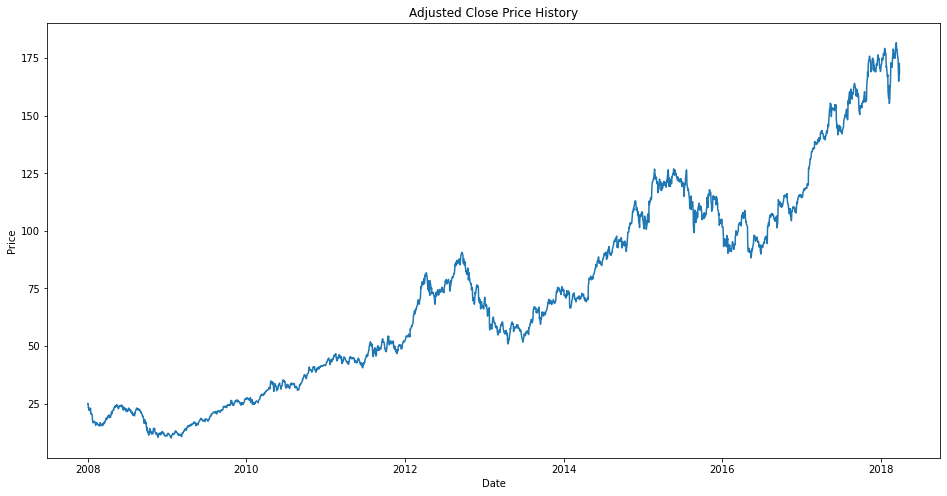

In [71]:
df2 = pd.read_csv("investment_tech_data.csv")
aapl_df = df2.loc[df2['ticker'] == 'AAPL']

#setting index as date
aapl_df['date'] = pd.to_datetime(aapl_df.date,format='%Y-%m-%d')
aapl_df.index = aapl_df['date']

plt.figure(figsize=(16,8))
plt.plot(aapl_df['adj_close'])
plt.title("Adjusted Close Price History")
plt.xlabel("Date")
plt.ylabel("Price")
plt.savefig("Images/adj_closing_hist_aapl.png")

/Users/allyson/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/allyson/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/allyson/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

r2: 0.9995177298634506, MSE: 0.38054453648864495


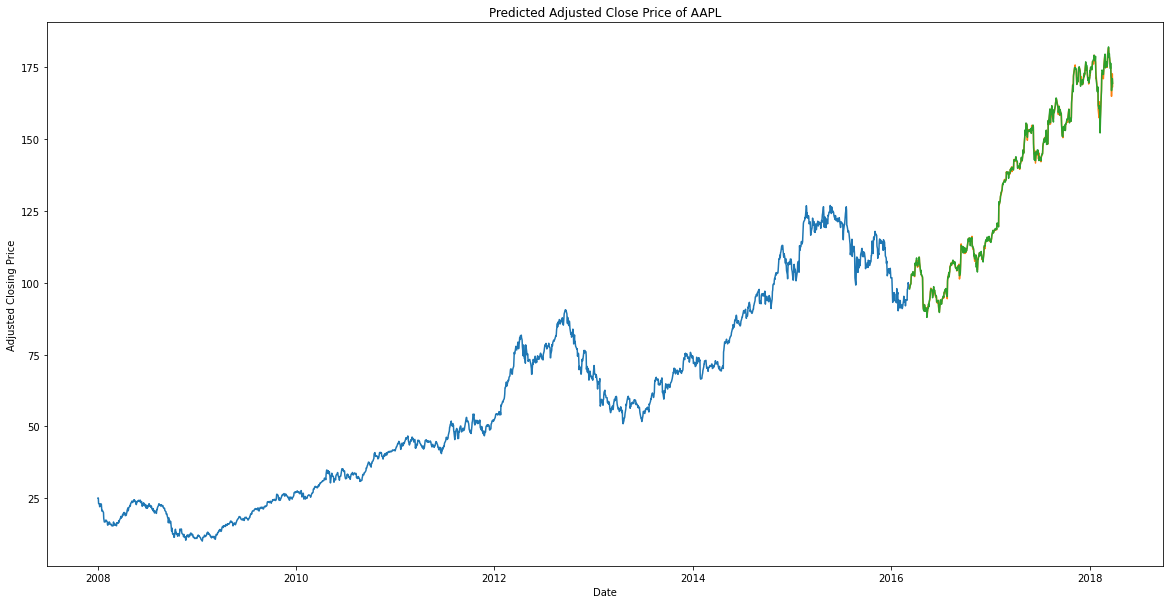

In [61]:
# Graph to show predicted trend for adjusted closing price for year 2015 to 2018

# Set index as date values
aapl_df['date'] = pd.to_datetime(aapl_df.date,format='%Y-%m-%d')
aapl_df.index = aapl_df['date']

# Sort the data
data = aapl_df.sort_index(ascending=True, axis=0)

# Create a new dataset. Select only needed columns
new_data = data.drop(['ticker','day_of_week_name'], axis=1)

train = new_data[:int(new_data.shape[0]*0.8)]
test = new_data[int(new_data.shape[0]*0.8):]

# Run model without data scaled
x_train = train.drop(['date','close','adj_close'], axis=1)
y_train = train['adj_close']
x_test = test.drop(['date','close','adj_close'], axis=1)
y_test = test['adj_close']

model = LinearRegression()
x_train.head()
model.fit(x_train,y_train)
preds = model.predict(x_test)
MSE = mean_squared_error(y_test, preds)
r2 = model.score(x_test, y_test)

test['Predictions'] = 0
test['Predictions'] = preds
test.head()
plt.plot(train['adj_close'])
plt.plot(test[['adj_close', 'Predictions']])
plt.title("Predicted Adjusted Close Price of AAPL")
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.savefig("Images/Pred_adj_closing_aapl.png")
print(f'r2: {r2}, MSE: {MSE}')

/Users/allyson/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/allyson/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/allyson/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

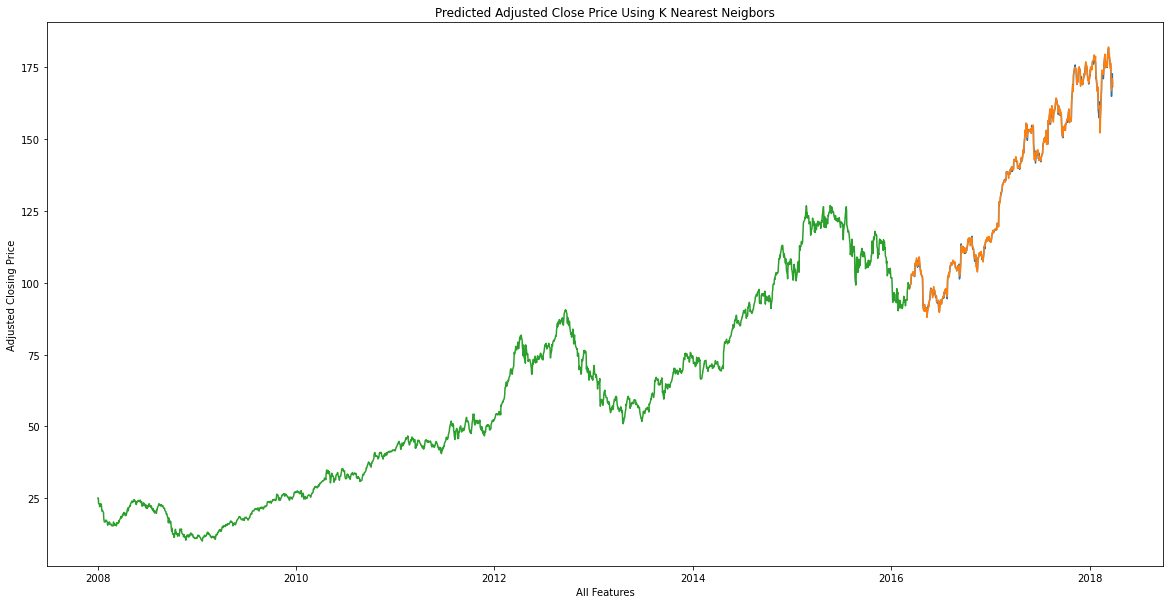

MSE:  1472.714, -0.862


In [62]:
# Set index as date values
aapl_df['date'] = pd.to_datetime(aapl_df.date,format='%Y-%m-%d')
aapl_df.index = aapl_df['date']

# Sort the data
aapl_df = aapl_df.sort_index(ascending=True, axis=0)

train = aapl_df[:int(new_data.shape[0]*0.8)]
test = aapl_df[int(new_data.shape[0]*0.8):]

X_train = train.drop(['ticker','day_of_week_name','date','close','adj_close'], axis=1)
y_train = train['adj_close']
X_test = test.drop(['ticker','day_of_week_name','date','close','adj_close'], axis=1)
y_test = test['adj_close']

#scaling data
X_train_scaled = StandardScaler().fit_transform(X_train)

X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

#using gridsearch to find the best parameter
#https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/?
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
predictions = model.predict(x_test)

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

# Plot now scaled graph of the actual and predicted values
test['Predictions'] = 0
test['Predictions'] = preds
plt.plot(test[['adj_close', 'Predictions']])
plt.plot(train['adj_close'])
plt.title("Predicted Adjusted Close Price Using K Nearest Neigbors")
plt.xlabel("All Features")
plt.ylabel("Adjusted Closing Price")
plt.savefig("Images/allfeatures_knn_aapl.png")
plt.show()
print(f"MSE: {MSE: .3f}, {r2: .3f}") 

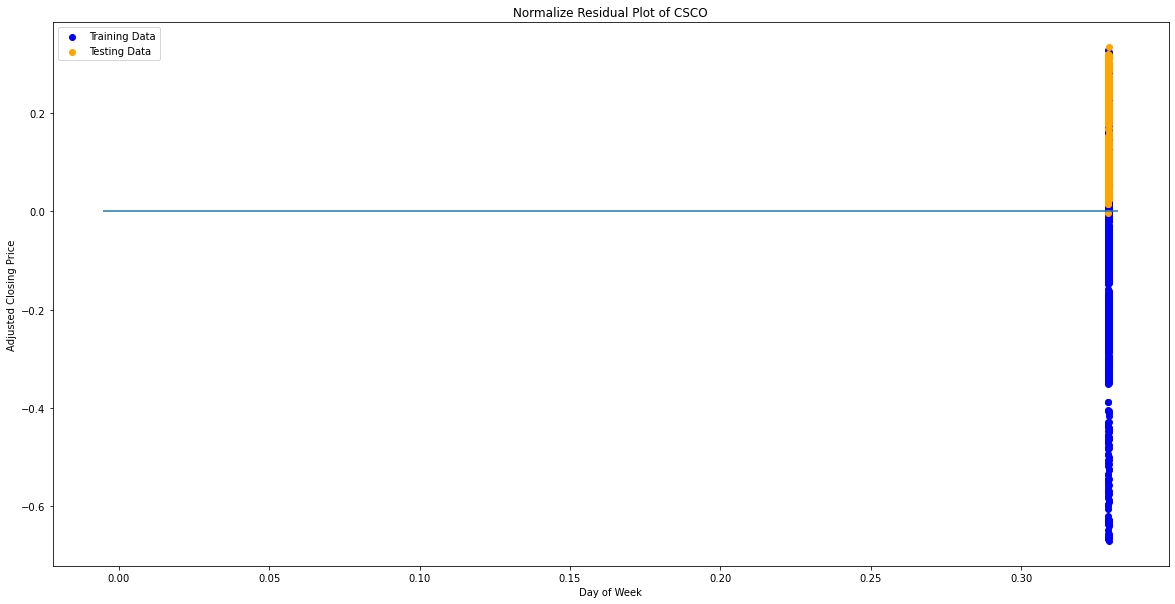

MSE: 0.02897716599772397, R2: -3.0515571553024436


In [63]:
#Test model with just 1 feature. Does day of the week after closing price?

df = pd.read_csv("investment_tech_data.csv")
csco_df = df.loc[df['ticker'] == 'CSCO']

#sort the dataset in ascending order
data = csco_df.sort_index(ascending=True,axis=0)

X = data[['day_of_week']].values.reshape(-1,1)
y = data['adj_close'].values.reshape(-1,1)

#Split the time series train/test data. 80% train, 20% test
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(y.shape[0]*0.8)]
y_test = y[int(y.shape[0]*0.8):]

X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

#transform the training and testing data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Create a LinearRegression model and fit it to the scaled training data
model = LinearRegression()
#train the model using the training data
model.fit(X_train_scaled, y_train_scaled)

# Make predictions using a fitted model
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Normalize Residual Plot of CSCO")
plt.xlabel("Day of Week")
plt.ylabel("Adjusted Closing Price")
plt.savefig("Images/dayofweek_csco.png")
plt.show()

# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
# A "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

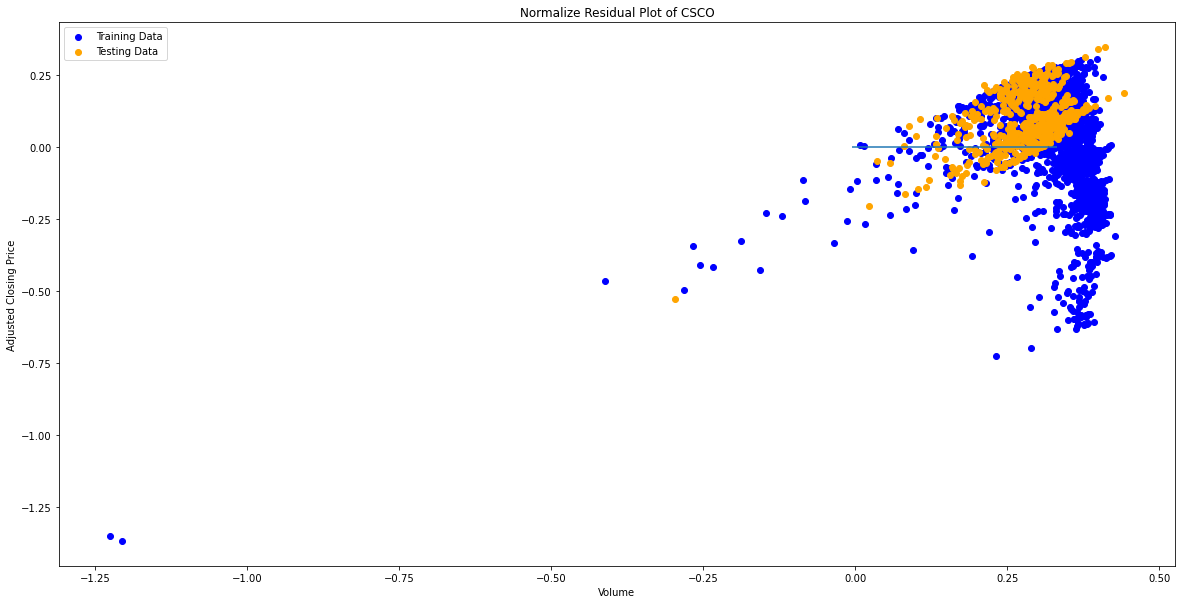

MSE: 0.018943411904546528, R2: -1.6486481132673703


In [64]:
#Test model with just 1 feature. Test correlation of volume and closing adjusted price

df = pd.read_csv("investment_tech_data.csv")
csco_df = df.loc[df['ticker'] == 'CSCO']

#sort the dataset in ascending order
data = csco_df.sort_index(ascending=True,axis=0)

X = data['volume'].values.reshape(-1,1)
y = data['adj_close'].values.reshape(-1,1)

#Split the time series train/test data. 70% train, 30% test
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(y.shape[0]*0.8)]
y_test = y[int(y.shape[0]*0.8):]

X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

#transform the training and testing data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Create a LinearRegression model and fit it to the scaled training data
model = LinearRegression()
#train the model using the training data
model.fit(X_train_scaled, y_train_scaled)

# Make predictions using a fitted model
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Normalize Residual Plot of CSCO")
plt.xlabel("Volume")
plt.ylabel("Adjusted Closing Price")
plt.savefig("Images/volume_csco.png")
plt.show()

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

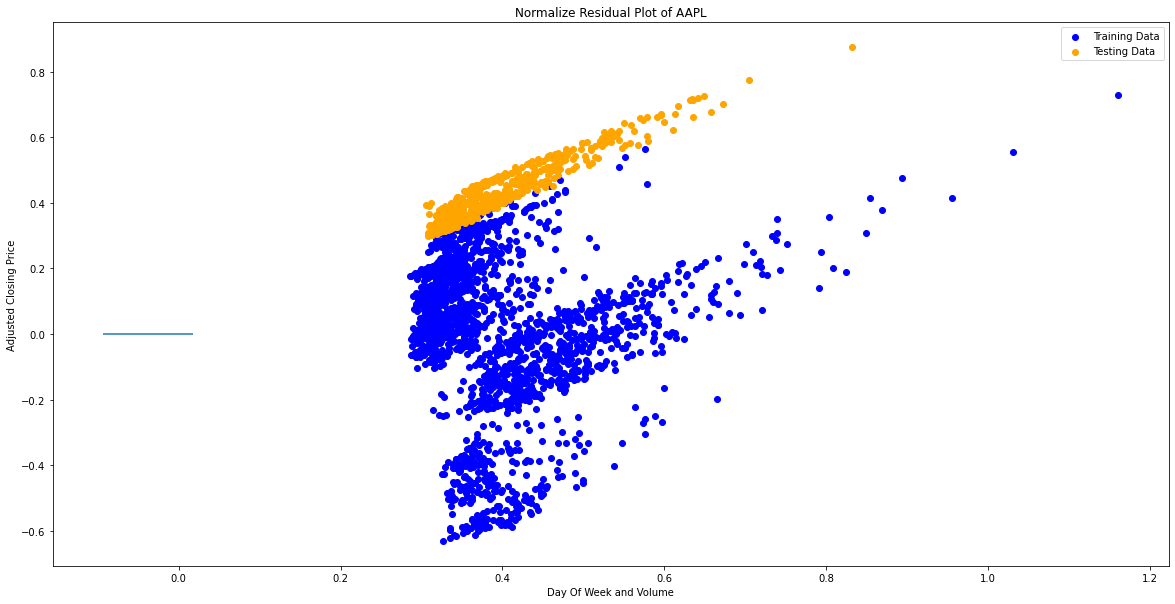

MSE: 0.20257798487651535, R2: -212.25424118278067


In [65]:
#Test model with just 2 feature. Test correlation of closing adjusted price and volume over time

df = pd.read_csv("investment_tech_data.csv")
aapl_df = df.loc[df['ticker'] == 'AAPL']

#sort the dataset in ascending order
data = aapl_df.sort_index(ascending=True,axis=0)

X = data[['day_of_week','volume']]
y = data['adj_close'].values.reshape(-1,1)

#Split the time series train/test data. 70% train, 30% test
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(y.shape[0]*0.8)]
y_test = y[int(y.shape[0]*0.8):]

X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

#transform the training and testing data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Create a LinearRegression model and fit it to the scaled training data
model = LinearRegression()
#train the model using the training data
model.fit(X_train_scaled, y_train_scaled)

# Make predictions using a fitted model
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Normalize Residual Plot of AAPL")
plt.xlabel("Day Of Week and Volume")
plt.ylabel("Adjusted Closing Price")
plt.savefig("Images/dayofweek_volume_aapl.png")
plt.show()

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

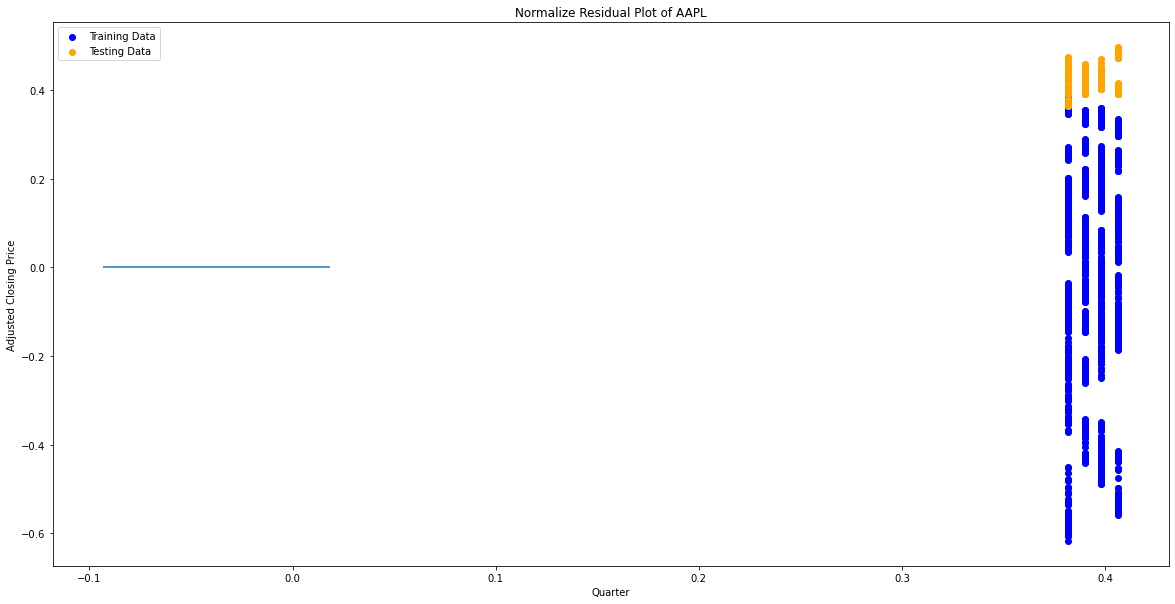

MSE: 0.18753939762265479, R2: -196.42309094580907


In [66]:
#Test model with just 1. Test correlation quarter over time.  Is the stock closing price seasonal?

#sort the dataset in ascending order
data = aapl_df.sort_index(ascending=True,axis=0)

X = data[['quarter']].values.reshape(-1,1)
y = data['adj_close'].values.reshape(-1,1)

#Split the time series train/test data. 70% train, 30% test
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(y.shape[0]*0.8)]
y_test = y[int(y.shape[0]*0.8):]

X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

#transform the training and testing data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Create a LinearRegression model and fit it to the scaled training data
model = LinearRegression()
#train the model using the training data
model.fit(X_train_scaled, y_train_scaled)

# Make predictions using a fitted model
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Normalize Residual Plot of AAPL")
plt.xlabel("Quarter")
plt.ylabel("Adjusted Closing Price")
plt.savefig("Images/quarter_aapl.png")
plt.show()

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

/Users/allyson/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



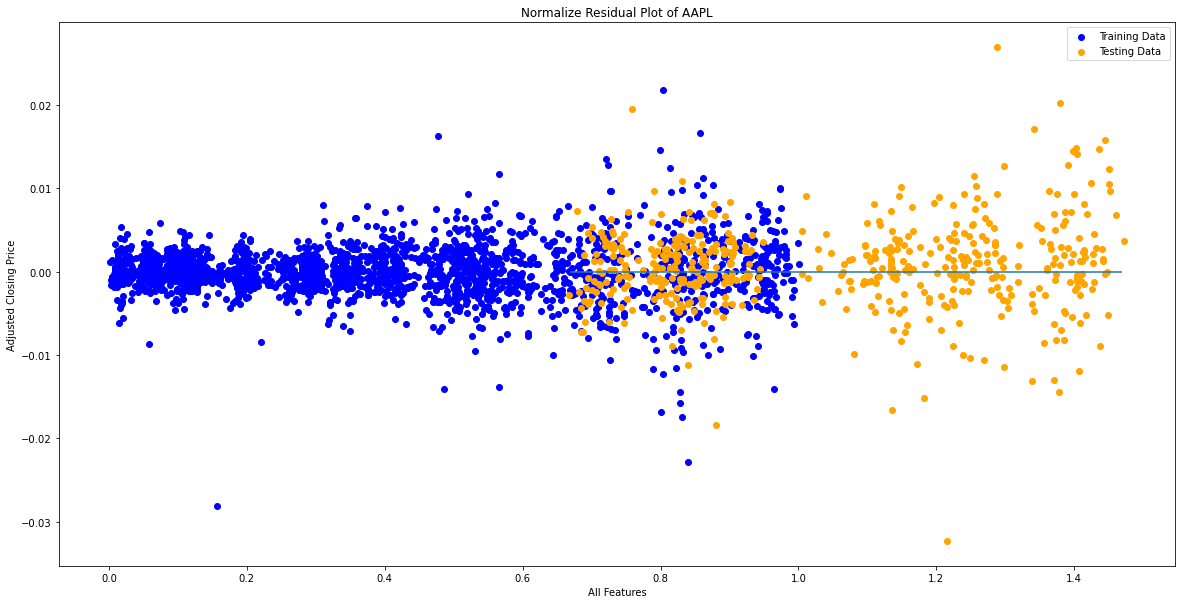

MSE: 2.785548427662758e-05, R2: 0.9995177298633985


In [67]:
# Include all the features except columns with string values and 'adjusted close'

# Set index as date values
aapl_df['date'] = pd.to_datetime(aapl_df.date,format='%Y-%m-%d')
aapl_df.index = aapl_df['date']

# Sort the data
data = aapl_df.sort_index(ascending=True, axis=0)

# Give the model all the features except columns with string values and 'adjusted close'
X = data.drop(['date','ticker','close','adj_close','day_of_week_name'], axis=1)
y = data['adj_close'].values.reshape(-1,1)
  
#Split the time series train/test data. 80% train, 20% test
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(y.shape[0]*0.8)]
y_test = y[int(y.shape[0]*0.8):]

X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

#transform the training and testing data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Create a LinearRegression model and fit it to the scaled training data
model = LinearRegression()
#train the model using the training data
model.fit(X_train_scaled, y_train_scaled)

predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Normalize Residual Plot of AAPL")
plt.xlabel("All Features")
plt.ylabel("Adjusted Closing Price")
plt.savefig("Images/allfeatures_linear_aapl.png")
plt.show()

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")


In [68]:
# LASSO model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)
predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.007895493608149968, R2: 0.863303012680579


/Users/allyson/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02256162439407383, tolerance: 0.016361795257481514



In [69]:
# ElasticNet model
from sklearn.linear_model import ElasticNet

elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)
predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}") 

MSE: 0.004003106955882757, R2: 0.9306930398598838
